In [1]:
#Setting up paths for data
data_root = "/home/jovyan/nnunet2-mig-7g-80gb-datavol-1/data/Brain-Tumor-Classification" 

tr_base  = data_root+"/Training"
te_base  = data_root+"/Testing"


In [2]:
#Setting up Transforms 
from pathlib import Path
from torch.utils.data import DataLoader, Subset, WeightedRandomSampler # remember subset when you divide into training and validation
from torchvision import datasets, transforms, utils, models # add models when you import pretrained models for transfer learning
import os
import torch
import numpy as np

IMG_SIZE = 512


train_tf = transforms.Compose([
    transforms.Lambda(lambda im: im.convert('L')),                 # use 'RGB' if truly 3-ch
    transforms.Grayscale(num_output_channels=1), 
    transforms.Resize((IMG_SIZE, IMG_SIZE), antialias=True),
    transforms.RandomAffine(degrees=10, translate=(0.02,0.02), scale=(0.95,1.05)),
    transforms.RandomApply([transforms.GaussianBlur(3, (0.1, 1.0))], p=0.2),
    transforms.ColorJitter(brightness=0.10, contrast=0.10),
    transforms.ToTensor(),
    #transforms.Lambda(zscore),
])

eval_tf = transforms.Compose([
    transforms.Lambda(lambda im: im.convert('L')),
    transforms.Grayscale(num_output_channels=1), 
    transforms.Resize((IMG_SIZE, IMG_SIZE), antialias=True),
    transforms.ToTensor(),
    #transforms.Lambda(zscore),
])
    

In [3]:
from torchvision import datasets
from torch.utils.data import Subset
import numpy as np

trainset = datasets.ImageFolder(tr_base, transform=train_tf)
valset   = datasets.ImageFolder(tr_base, transform=eval_tf)
testset  = datasets.ImageFolder(te_base, transform=eval_tf)

print(trainset.classes)    # should be ['glioma','meningioma','no_tumor','pituitary']
class_names = trainset.classes

# train/val split
val_fraction = 0.2
idxs = list(range(len(valset)))
rng = np.random.default_rng(42)
rng.shuffle(idxs)

n_val   = int(len(idxs) * val_fraction)
val_idx = idxs[:n_val]
train_idx = idxs[n_val:]

trainset = Subset(trainset, train_idx)
valset   = Subset(valset,   val_idx)
# testset stays as is

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


In [4]:
def get_targets_from_dataset(ds) -> np.ndarray:
    """Return class indices for ImageFolder or Subset(ImageFolder)."""
    if isinstance(ds, Subset):
        base, idxs = ds.dataset, ds.indices
        if hasattr(base, "targets"):
            return np.asarray(base.targets, dtype=int)[idxs]
        return np.asarray([base.samples[i][1] for i in idxs], dtype=int)

    # ImageFolder
    if hasattr(ds, "targets"):
        return np.asarray(ds.targets, dtype=int)

    return np.asarray([y for _, y in ds.samples], dtype=int)

In [5]:
targets_4c = get_targets_from_dataset(trainset)   # original 4-class labels
class_sample_count = np.bincount(targets_4c)

# inverse frequency weights
weights = 1.0 / class_sample_count
sample_weights = torch.DoubleTensor([weights[t] for t in targets_4c])

sampler = torch.utils.data.WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),  
    replacement=True
)


In [6]:
from torch.utils.data import Dataset

class HierarchicalTumorDataset(Dataset):
    """
    Wraps an existing dataset (ImageFolder or Subset(ImageFolder))
    and returns: image, y_bin, y_sub

    y_bin: 0 = no_tumor, 1 = tumor
    y_sub: 0 = glioma, 1 = meningioma, 2 = pituitary, -1 = no_tumor (ignored)
    """
    def __init__(self, base_dataset, class_names, subtype_ignore_index=-1):
        self.base = base_dataset
        self.subtype_ignore_index = subtype_ignore_index

        # original label indices from ImageFolder class order
        self.glioma_idx     = class_names.index("glioma_tumor")
        self.meningioma_idx = class_names.index("meningioma_tumor")
        self.no_tumor_idx   = class_names.index("no_tumor")
        self.pituitary_idx  = class_names.index("pituitary_tumor")

        # binary mapping: tumor vs no_tumor
        self.bin_map = {
            self.glioma_idx: 1,
            self.meningioma_idx: 1,
            self.pituitary_idx: 1,
            self.no_tumor_idx: 0,
        }

        # subtype mapping (no_tumor gets ignore_index)
        self.subtype_map = {
            self.glioma_idx: 0,
            self.meningioma_idx: 1,
            self.pituitary_idx: 2,
            self.no_tumor_idx: self.subtype_ignore_index,
        }

    def __len__(self):
        return len(self.base)

    def __getitem__(self, idx):
        x, y_orig = self.base[idx]       # y_orig in {0,1,2,3} from ImageFolder
        y_bin = self.bin_map[y_orig]     # 0/1
        y_sub = self.subtype_map[y_orig] # 0/1/2 or -1
        return x, y_bin, y_sub

In [7]:
train_hier = HierarchicalTumorDataset(trainset, class_names)
val_hier   = HierarchicalTumorDataset(valset,   class_names)
test_hier  = HierarchicalTumorDataset(testset,  class_names)

In [8]:
from torch.utils.data import DataLoader

BATCH =4
WORKERS = 4
EPOCHS = 500
LR = 3e-4
# trainset, valset, testset are Subset(ImageFolder, ...)
# class_names comes from ImageFolder(tr_base).classes

train_hier = HierarchicalTumorDataset(trainset, class_names)
val_hier   = HierarchicalTumorDataset(valset,   class_names)

train_loader = DataLoader(
    train_hier,
    batch_size=BATCH,
    sampler=sampler,         # if you use one
    num_workers=WORKERS,
    pin_memory=True
)

val_loader = DataLoader(
    val_hier,
    batch_size=BATCH*2,
    shuffle=False,
    num_workers=WORKERS,
    pin_memory=True,
    drop_last=False
)

test_loader = DataLoader(
    test_hier,
    batch_size=BATCH*2,
    shuffle=False,
    num_workers=WORKERS,
    pin_memory=True,
    drop_last=False
)

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class UNetHierMTL(nn.Module):
    """
    U-Net autoencoder with hierarchical classification head.

    Outputs:
      - recon:      reconstruction (B, out_channels, H, W)
      - logit_bin:  tumor vs no_tumor (B,)  -> use BCEWithLogitsLoss
      - logits_sub: subtype logits (B, n_subtypes) -> use CrossEntropyLoss(ignore_index=-1)
      - latent:     latent feature vector (B, cls_hidden)
    """
    def __init__(
        self,
        in_channels=1,
        out_channels=1,
        n_subtypes=3,          # glioma, meningioma, pituitary
        features=(64, 128, 256, 512),
        cls_hidden=256,
        dropout=0.2,
    ):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.n_subtypes = n_subtypes

        # ---------- Encoder ----------
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(2, 2)

        ch_in = in_channels
        for ch_out in features:
            self.downs.append(self._block(ch_in, ch_out))
            ch_in = ch_out

        # ---------- Bottleneck ----------
        self.bottleneck = self._block(features[-1], features[-1] * 2)
        bottleneck_ch = features[-1] * 2

        # ---------- Decoder ----------
        self.ups = nn.ModuleList()
        for ch in reversed(features):
            self.ups.append(nn.ConvTranspose2d(bottleneck_ch, ch, kernel_size=2, stride=2))
            self.ups.append(self._block(ch * 2, ch))  # skip concat doubles channels
            bottleneck_ch = ch

        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

        # ---------- Hierarchical classification head ----------
        self.gap = nn.AdaptiveAvgPool2d(1)

        # shared latent projection (backbone part of HierarchicalNet)
        self.cls_proj = nn.Sequential(
            nn.Flatten(),                     # (B, C, 1, 1) -> (B, C)
            nn.Linear(features[-1] * 2, cls_hidden),
            nn.ReLU(inplace=True),
        )

        # binary head: tumor vs no_tumor (1 logit)
        self.head_bin = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(cls_hidden, 1),
        )

        # subtype head: glioma / meningioma / pituitary
        self.head_sub = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(cls_hidden, n_subtypes),
        )

    @staticmethod
    def _block(in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x, return_latent: bool = False):
        # ---------- Encoder with skips ----------
        skips = []
        for down in self.downs:
            x = down(x)
            skips.append(x)
            x = self.pool(x)

        # ---------- Bottleneck ----------
        x = self.bottleneck(x)
        bottleneck_feat = x  # (B, C_bottleneck, H', W')

        # ---------- Classification branch ----------
        pooled = self.gap(bottleneck_feat)          # (B, C_bottleneck, 1, 1)
        latent = self.cls_proj(pooled)              # (B, cls_hidden)

        logit_bin = self.head_bin(latent).squeeze(-1)   # (B,)
        logits_sub = self.head_sub(latent)              # (B, n_subtypes)

        # ---------- Decoder ----------
        skips = skips[::-1]
        for i in range(0, len(self.ups), 2):
            x = self.ups[i](x)  # up-conv
            skip = skips[i // 2]
            if x.shape[-2:] != skip.shape[-2:]:
                x = F.interpolate(x, size=skip.shape[-2:], mode="bilinear", align_corners=False)
            x = torch.cat([skip, x], dim=1)
            x = self.ups[i + 1](x)

        recon = self.final_conv(x)

        out = {
            "recon": recon,
            "logit_bin": logit_bin,
            "logits_sub": logits_sub,
        }
        if return_latent:
            out["latent"] = latent
        return out


# quick sanity check
if __name__ == "__main__":
    model = UNetHierMTL(in_channels=1, out_channels=1, n_subtypes=3)
    inp = torch.randn(1, 1, 512, 512)
    out = model(inp, return_latent=True)
    print(out["recon"].shape, out["logit_bin"].shape, out["logits_sub"].shape, out["latent"].shape)


torch.Size([1, 1, 512, 512]) torch.Size([1]) torch.Size([1, 3]) torch.Size([1, 256])


In [10]:
import torch

# Use the same model + wrapper as above
base_model = UNetHierMTL(in_channels=1, out_channels=1, n_subtypes=3)
model = UNetHierMTLWrapper(base_model).eval()

dummy = torch.randn(1, 1, 512, 512)  # example input

torch.onnx.export(
    model,
    dummy,
    "UNetHierMTL.onnx",
    input_names=["input"],
    output_names=["recon", "logit_bin", "logits_sub", "latent"],
    opset_version=13,
    do_constant_folding=True
)

NameError: name 'UNetHierMTLWrapper' is not defined

In [10]:
import torch
import contextlib
import torch.nn.functional as F

def epoch_run(
    model,
    loader,
    device,
    train: bool,
    use_amp: bool,          # keep flag, but we only use it for autocast
    optimizer=None,
    ema_recon: float = 1.0,
    ema_cls: float = 1.0,
    beta: float = 0.99,
    alpha_sub: float = 1.0,
    bin_thresh: float = 0.5
):
    """
    Hierarchical multi-task epoch:

      - reconstruction
      - binary tumor vs no_tumor
      - subtype classification for tumor cases

    Dataloader must yield: xb, y_bin, y_sub

    Returns
    -------
    avg_loss, acc_4class, bin_acc, sub_acc_tumor, avg_recon_loss, avg_cls_loss
    """

    recon_criterion = torch.nn.MSELoss()
    bin_criterion   = torch.nn.BCEWithLogitsLoss()
    sub_criterion   = torch.nn.CrossEntropyLoss(ignore_index=-1)

    assert (train and optimizer is not None) or (not train)

    model.train() if train else model.eval()

    total = 0
    running_loss = 0.0
    running_recon = 0.0
    running_cls = 0.0

    correct_4 = 0
    correct_bin = 0
    total_bin = 0

    correct_sub_tumor = 0
    total_sub_tumor = 0

    cm = contextlib.nullcontext() if train else torch.no_grad()
    amp_enabled = use_amp and (device.type == 'cuda')

    with cm:
        for xb, y_bin, y_sub in loader:
            xb    = xb.to(device, non_blocking=True)
            y_bin = y_bin.to(device, non_blocking=True).float()
            y_sub = y_sub.to(device, non_blocking=True)

            with torch.amp.autocast('cuda', enabled=amp_enabled):
                out = model(xb)
                recon      = out["recon"]
                logit_bin  = out["logit_bin"]    # (B,)
                logits_sub = out["logits_sub"]   # (B, 3)

                # --- reconstruction + binary loss ---
                recon_loss = recon_criterion(recon, xb)
                bin_loss   = bin_criterion(logit_bin, y_bin)

                # --- subtype loss: ONLY if any valid labels (y_sub != -1) ---
                valid_sub_mask = (y_sub != -1)
                if valid_sub_mask.any():
                    sub_loss = sub_criterion(
                        logits_sub[valid_sub_mask],
                        y_sub[valid_sub_mask]
                    )
                else:
                    sub_loss = torch.zeros((), device=device)

                cls_loss = bin_loss + alpha_sub * sub_loss

                # --- EMA updates (detach) ---
                ema_recon = beta * ema_recon + (1.0 - beta) * float(recon_loss.detach())
                ema_cls   = beta * ema_cls   + (1.0 - beta) * float(cls_loss.detach())

                # --- normalized losses ---
                recon_norm = recon_loss / max(ema_recon, 1e-12)
                cls_norm   = cls_loss   / max(ema_cls,   1e-12)

                loss = recon_norm + cls_norm

            if train:
                optimizer.zero_grad(set_to_none=True)
                loss.backward()
                optimizer.step()

            # ---- Accumulate losses ----
            bs = xb.size(0)
            running_loss  += loss.detach().float().item() * bs
            running_recon += recon_norm.detach().float().item() * bs
            running_cls   += cls_norm.detach().float().item() * bs
            total += bs

            # ---- Predictions ----
            prob_bin = torch.sigmoid(logit_bin)          # (B,)
            pred_bin = (prob_bin >= bin_thresh).long()   # 0=no_tumor, 1=tumor
            pred_sub = logits_sub.argmax(dim=1)          # (B,)

            # 4-class labels: 0,1,2=subtypes; 3=no_tumor
            pred_4 = torch.where(
                pred_bin == 0,
                torch.full_like(pred_sub, 3),
                pred_sub
            )
            true_4 = torch.where(
                y_bin.long() == 0,
                torch.full_like(y_sub, 3),
                y_sub
            )

            correct_4 += (pred_4 == true_4).sum().item()

            # binary accuracy
            correct_bin += (pred_bin == y_bin.long()).sum().item()
            total_bin   += bs

            # subtype accuracy on tumor cases only
            tumor_mask = (y_bin.long() == 1) & (y_sub != -1)
            if tumor_mask.any():
                correct_sub_tumor += (pred_sub[tumor_mask] == y_sub[tumor_mask]).sum().item()
                total_sub_tumor   += tumor_mask.sum().item()

    avg_loss = running_loss / total
    avg_recon_loss = running_recon / total
    avg_cls_loss = running_cls / total

    acc_4class = correct_4 / total
    bin_acc = correct_bin / total_bin if total_bin > 0 else float('nan')
    sub_acc_tumor = (
        correct_sub_tumor / total_sub_tumor if total_sub_tumor > 0 else float('nan')
    )

    return avg_loss, acc_4class, bin_acc, sub_acc_tumor, avg_recon_loss, avg_cls_loss


In [11]:
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

def get_device():
    return torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def to_device(batch, device):
    x, y = batch
    return x.to(device, non_blocking=True), y.to(device, non_blocking=True)

In [12]:
xb, y_bin, y_sub = next(iter(train_loader))
print(xb.shape, y_bin.shape, y_sub.shape)
print("unique y_bin:", torch.unique(y_bin))
print("unique y_sub:", torch.unique(y_sub))

torch.Size([4, 1, 512, 512]) torch.Size([4]) torch.Size([4])
unique y_bin: tensor([1])
unique y_sub: tensor([0, 1])


In [13]:
# ----------------------------
# 3) Training utilities
# ----------------------------
class EarlyStopper:
    def __init__(self, patience=8, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.best = None
        self.count = 0

    def step(self, metric):
        if self.best is None or metric > self.best + self.min_delta:
            self.best = metric
            self.count = 0
            return False  # do not stop

In [14]:
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from torch import amp
import json

seed=2025
set_seed(seed)
device = get_device()
print("Device:", device)

DATA_ROOT = data_root 
BATCH = 32
EPOCHS = 100
LR = 3e-4
FREEZE_BACKBONE = False  # set True to train only the last layer first

#counts = torch.tensor([670, 653, 328, 652], dtype=torch.float32)
#beta = 0.999  # can be tuned in [0.99, 0.9999]

#effective_num = 1.0 - beta ** counts
#weights = (1.0 - beta) / effective_num
#weights = weights / weights.sum() * len(counts)
#print(weights)

#trainset, valset, testset, class_names = build_datasets(DATA_ROOT, img_size=224, val_fraction=0.15)
print("Classes:", class_names)

#scaler = amp.GradScaler('cuda', enabled=(device.type=='cuda'))
history = {
    "train_loss":      [],
    "train_acc4":      [],
    "train_bin_acc":   [],
    "train_sub_acc":   [],
    "train_recon":     [],
    "train_cls":       [],
    "val_loss":        [],
    "val_acc4":        [],
    "val_bin_acc":     [],
    "val_sub_acc":     [],
    "val_recon":       [],
    "val_cls":         [],
}

train_loader = DataLoader(
    train_hier,
    batch_size=BATCH,
    sampler=sampler,
    num_workers=WORKERS,
    pin_memory=True
)

val_loader = DataLoader(
    val_hier,
    batch_size=BATCH*2,
    shuffle=False,
    num_workers=WORKERS,
    pin_memory=True,
    drop_last=False
)

test_loader = DataLoader(
    test_hier,
    batch_size=BATCH*2,
    shuffle=False,
    num_workers=WORKERS,
    pin_memory=True,
    drop_last=False
)

print("Train uses sampler:", train_loader.sampler.__class__.__name__)
print("Val uses sampler:  ", val_loader.sampler.__class__.__name__)
print("Test uses sampler: ", test_loader.sampler.__class__.__name__)

model = UNetHierMTL(in_channels=1, out_channels=1, n_subtypes=3)
model.to(device)

scaler = amp.GradScaler('cuda', enabled=(device.type=='cuda'))
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)


best_loss, best_acc, best_path, best_path_acc = 1000, 0.0, "best_AE_Loss_brain_tumor_MTL_Lat_Hier.pt", "best_AE_Acc_brain_tumor_MTL_Lat_Hier.pt"
stopper = EarlyStopper(patience=7, min_delta=1e-4)

for epoch in range(1, EPOCHS+1):
    train_loss, train_acc4, train_bin_acc, train_sub_acc, train_recon, train_cls = epoch_run(
        model, train_loader, device,
        train=True, use_amp=False,          # start with False, can set True later
        optimizer=optimizer,
        ema_recon=0.0004, ema_cls=1.0, beta=0.99
    )

    val_loss, val_acc4, val_bin_acc, val_sub_acc, val_recon, val_cls = epoch_run(
        model, val_loader, device,
        train=False, use_amp=False,
        ema_recon=0.0004, ema_cls=1.0, beta=0.99
    )

    print(
        f"Train | total {train_loss:.4f} | acc4 {train_acc4:.3f} | "
        f"bin {train_bin_acc:.3f} | sub_tumor {train_sub_acc:.3f} | "
        f"recon {train_recon:.4f} | cls {train_cls:.4f}"
    )
    print(
        f"Val   | total {val_loss:.4f} | acc4 {val_acc4:.3f} | "
        f"bin {val_bin_acc:.3f} | sub_tumor {val_sub_acc:.3f} | "
        f"recon {val_recon:.4f} | cls {val_cls:.4f}"
    )

    scheduler.step()

    # log
    history["train_loss"].append(train_loss)
    history["train_acc4"].append(train_acc4)
    history["train_bin_acc"].append(train_bin_acc)
    history["train_sub_acc"].append(train_sub_acc)
    history["train_recon"].append(train_recon)
    history["train_cls"].append(train_cls)

    history["val_loss"].append(val_loss)
    history["val_acc4"].append(val_acc4)
    history["val_bin_acc"].append(val_bin_acc)
    history["val_sub_acc"].append(val_sub_acc)
    history["val_recon"].append(val_recon)
    history["val_cls"].append(val_cls)

    # ---------------- best model tracking ----------------
    color = ""
    end_color = "\033[0m"
    style_bold = "\033[1m"
    suffix = ""

    # For consistency, use 4-class accuracy for "acc"
    val_acc = val_acc4

    if val_loss < best_loss and val_acc > best_acc:
        best_loss = val_loss
        best_acc = val_acc
        color = "\033[96m"  # cyan
        suffix = " 🟢⭐ (new best loss & acc)"
        torch.save({"model": model.state_dict(),
                    "classes": class_names}, best_path)

    elif val_loss < best_loss:
        best_loss = val_loss
        color = "\033[92m"  # green
        suffix = " ✅ (new best loss)"
        torch.save({"model": model.state_dict(),
                    "classes": class_names}, best_path)

    elif val_acc > best_acc:
        best_acc = val_acc
        color = "\033[94m"  # blue
        suffix = " 💙 (new best acc)"
        torch.save({"model": model.state_dict(),
                    "classes": class_names}, best_path_acc)

    print(f"{color}{style_bold}"
          f"Epoch {epoch:02d}/{EPOCHS} | "
          f"train_loss={train_loss:.4f} acc4={train_acc4:.4f} | "
          f"val_loss={val_loss:.4f} acc4={val_acc4:.4f}"
          f"{suffix}{end_color}")



    if stopper.step(val_acc):
        print("Early stopping triggered.")
        break

print(f"Best val loss: {best_loss:.4f}. Saved to: {best_path}")

with open("history_AE_MTL_latent_Hier.json", "w") as f:
    json.dump(history, f)

Device: cuda
Classes: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
Train uses sampler: WeightedRandomSampler
Val uses sampler:   SequentialSampler
Test uses sampler:  SequentialSampler
Train | total 3.9875 | acc4 0.571 | bin 0.842 | sub_tumor 0.626 | recon 2.8667 | cls 1.1209
Val   | total 3.7587 | acc4 0.560 | bin 0.872 | sub_tumor 0.642 | recon 2.7275 | cls 1.0312
Epoch 01/100 | train_loss=3.9875 acc4=0.5711 | val_loss=3.7587 acc4=0.5603 🟢⭐ (new best loss & acc)
Train | total 3.0238 | acc4 0.662 | bin 0.889 | sub_tumor 0.687 | recon 2.0514 | cls 0.9724
Val   | total 1.7857 | acc4 0.634 | bin 0.886 | sub_tumor 0.694 | recon 0.7645 | cls 1.0212
Epoch 02/100 | train_loss=3.0238 acc4=0.6619 | val_loss=1.7857 acc4=0.6345 🟢⭐ (new best loss & acc)
Train | total 2.3106 | acc4 0.727 | bin 0.903 | sub_tumor 0.748 | recon 1.4603 | cls 0.8503
Val   | total 1.6782 | acc4 0.603 | bin 0.803 | sub_tumor 0.696 | recon 0.6522 | cls 1.0260
Epoch 03/100 | train_loss=2.3106 acc4=0.

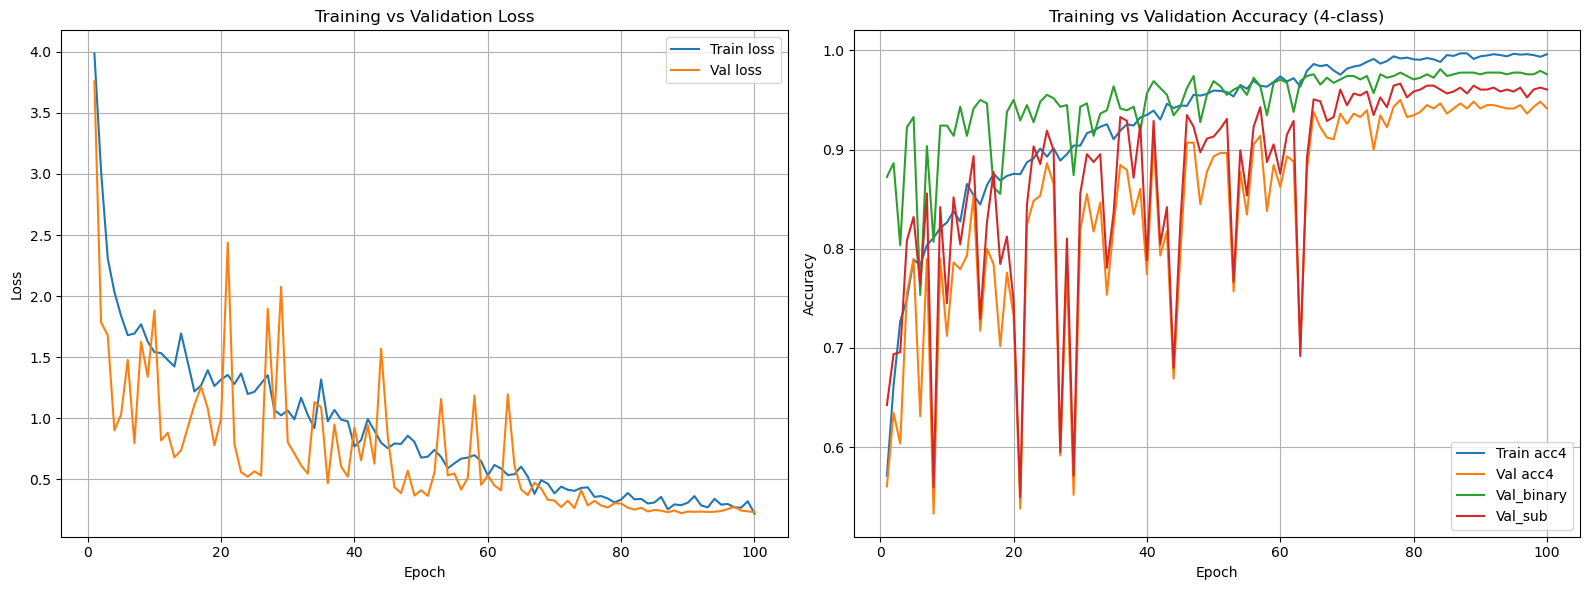

In [17]:
import matplotlib.pyplot as plt
import json

filename = "history_AE_MTL_latent_Hier.json"
with open(filename, "r") as f:
    history = json.load(f)

epochs = range(1, len(history["train_loss"]) + 1)

# ---- Create subplots (1 row, 2 columns) ----
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# ----------------------
# Left: Loss curves
# ----------------------


ax = axs[0]
ax.plot(epochs, history["train_loss"], label="Train loss")
ax.plot(epochs, history["val_loss"],   label="Val loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Training vs Validation Loss")
ax.legend()
ax.grid(True)

# ----------------------
# Right: Accuracy curves
# ----------------------
ax = axs[1]
ax.plot(epochs, history["train_acc4"], label="Train acc4")
ax.plot(epochs, history["val_acc4"],   label="Val acc4")
ax.plot(epochs, history["val_bin_acc"], label="Val_binary")
ax.plot(epochs, history["val_sub_acc"], label="Val_sub")
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
ax.set_title("Training vs Validation Accuracy (4-class)")
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.savefig("AE_MTL_plots.png", bbox_inches='tight', pad_inches=0)
plt.show()


In [15]:
from sklearn.metrics import classification_report, confusion_matrix
best_path = "best_AE_Loss_brain_tumor_MTL_Lat_Hier.pt"
device = get_device()
print("Device:", device)

if test_loader is not None:
    ckpt = torch.load(best_path, map_location=device)
    model.load_state_dict(ckpt["model"])
    model = model.to(device)
    model.eval()

    all_preds_4 = []
    all_true_4  = []

    flat_class_names = ["glioma", "meningioma", "pituitary", "no_tumor"]

    with torch.no_grad():
        for xb, y_bin, y_sub in test_loader:
            xb    = xb.to(device, non_blocking=True)
            y_bin = y_bin.to(device, non_blocking=True).float()
            y_sub = y_sub.to(device, non_blocking=True)

            out = model(xb)
            logit_bin  = out["logit_bin"]
            logits_sub = out["logits_sub"]

            # binary decision
            prob_bin = torch.sigmoid(logit_bin)
            pred_bin = (prob_bin >= 0.5).long()          # (B,)

            # subtype prediction
            pred_sub = logits_sub.argmax(dim=1)          # (B,)

            # 4-class predictions: 0,1,2=subtypes; 3=no_tumor
            pred_4 = torch.where(
                pred_bin == 0,
                torch.full_like(pred_sub, 3),
                pred_sub
            )

            true_4 = torch.where(
                y_bin.long() == 0,
                torch.full_like(y_sub, 3),
                y_sub
            )

            all_preds_4.append(pred_4.cpu())
            all_true_4.append(true_4.cpu())

    y_pred = torch.cat(all_preds_4).numpy()
    y_true = torch.cat(all_true_4).numpy()

    print("\nTest classification report (4-class hierarchical):")
    print(classification_report(y_true, y_pred, target_names=flat_class_names, digits=4))
    print("\nConfusion matrix:")
    print(confusion_matrix(y_true, y_pred))

Device: cuda


/tmp/ipykernel_6361/3880441210.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(best_path, map_location=device)



Test classification report (4-class hierarchical):
              precision    recall  f1-score   support

      glioma     1.0000    0.2500    0.4000       100
  meningioma     0.7676    0.9478    0.8482       115
   pituitary     0.8493    0.8378    0.8435        74
    no_tumor     0.7247    1.0000    0.8404       129

    accuracy                         0.7775       418
   macro avg     0.8354    0.7589    0.7330       418
weighted avg     0.8244    0.7775    0.7378       418


Confusion matrix:
[[ 25  28  10  37]
 [  0 109   1   5]
 [  0   5  62   7]
 [  0   0   0 129]]


In [16]:
import torch
import numpy as np

@torch.no_grad()
def extract_latents_4class(loader, model, device):
    """
    Extract latent vectors and corresponding 4-class labels

    4-class encoding:
      0 = glioma
      1 = meningioma
      2 = pituitary
      3 = no_tumor

    Assumes loader yields: xb, y_bin, y_sub
      y_bin: 0/1 (no_tumor / tumor)
      y_sub: 0/1/2 or -1 for no_tumor
    """
    model.eval()
    Z, Y4 = [], []

    for xb, y_bin, y_sub in loader:
        xb    = xb.to(device, non_blocking=True)
        y_bin = y_bin.to(device, non_blocking=True)
        y_sub = y_sub.to(device, non_blocking=True)

        out = model(xb, return_latent=True)
        z = out["latent"]             # (B, cls_hidden)

        # build 4-class ground truth labels
        # if y_bin == 0 -> 3 (no_tumor), else y_sub (0,1,2)
        y4 = torch.where(
            y_bin.long() == 0,
            torch.full_like(y_sub, 3),
            y_sub
        )

        Z.append(z.cpu())
        Y4.append(y4.cpu())

    Z = torch.cat(Z, dim=0).numpy()     # [N, cls_hidden]
    Y4 = torch.cat(Y4, dim=0).numpy()   # [N]
    return Z, Y4

# usage
Z, Y4 = extract_latents_4class(val_loader, model, device)
print("Latent space shape:", Z.shape)
print("Labels shape:", Y4.shape, "unique:", np.unique(Y4))


Latent space shape: (580, 256)
Labels shape: (580,) unique: [0 1 2 3]


In [28]:
@torch.no_grad()
def extract_latents_tumor_only(loader, model, device):
    """
    Latents + subtype labels for tumor cases only.
    y_sub: 0=glioma, 1=meningioma, 2=pituitary
    """
    model.eval()
    Z, Y_sub_all = [], []

    for xb, y_bin, y_sub in loader:
        xb    = xb.to(device, non_blocking=True)
        y_bin = y_bin.to(device, non_blocking=True)
        y_sub = y_sub.to(device, non_blocking=True)

        out = model(xb, return_latent=True)
        z = out["latent"]  # (B, cls_hidden)

        tumor_mask = (y_bin.long() == 1) & (y_sub != -1)
        if tumor_mask.any():
            Z.append(z[tumor_mask].cpu())
            Y_sub_all.append(y_sub[tumor_mask].cpu())

    Z = torch.cat(Z, dim=0).numpy()
    Y_sub_all = torch.cat(Y_sub_all, dim=0).numpy()
    return Z, Y_sub_all


In [42]:
!pip install --upgrade scikit-learn umap-learn

Looking in indexes: http://pulp-web-svc.pulp-system.svc.cluster.local:24880/pypi/pypi/simple/


In [41]:
import umap

ImportError: cannot import name 'get_tags' from 'sklearn.utils' (/opt/conda/lib/python3.11/site-packages/sklearn/utils/__init__.py)

In [17]:
import umap
import matplotlib.pyplot as plt

# Extract latent spaces
Z_val, y_val = extract_latents_4class(val_loader, model, device)
Z_test, y_test = extract_latents_4class(test_loader, model, device)

# Fit UMAP on validation set only
umap_model = umap.UMAP(
    n_components=2,
    n_neighbors=15,
    min_dist=0.1,
    metric="euclidean",
    random_state=42
)

Z_val_2d = umap_model.fit_transform(Z_val)

# Project test set into same embedding
Z_test_2d = umap_model.transform(Z_test)

/opt/conda/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


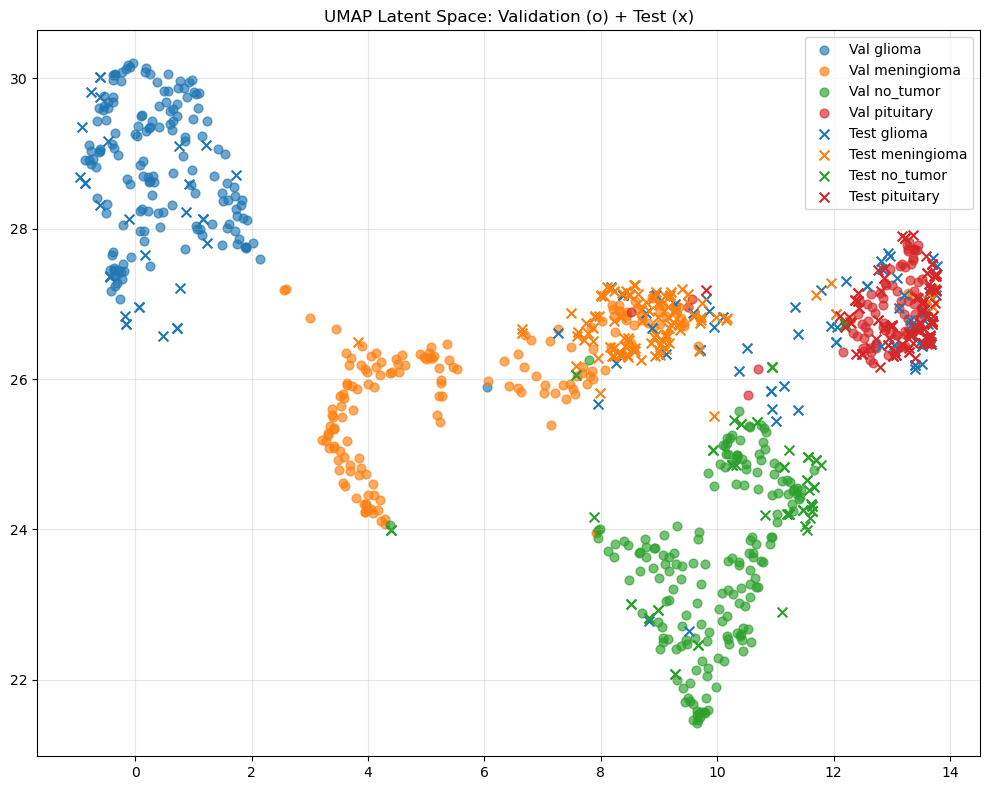

In [20]:
import numpy as np

classes = ["glioma", "meningioma", "no_tumor", "pituitary"]
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]

plt.figure(figsize=(10, 8))

# --- Plot validation (circles) ---
for c in np.unique(y_val):
    idx = (y_val == c)
    plt.scatter(
        Z_val_2d[idx, 0], Z_val_2d[idx, 1],
        c=colors[c], label=f"Val {classes[c]}",
        marker='o', alpha=0.65, s=40
    )

# --- Plot test (crosses) ---
for c in np.unique(y_test):
    idx = (y_test == c)
    plt.scatter(
        Z_test_2d[idx, 0], Z_test_2d[idx, 1],
        c=colors[c], label=f"Test {classes[c]}",
        marker='x', s=50, linewidths=1.5
    )

plt.title("UMAP Latent Space: Validation (o) + Test (x)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("UMAP_MTL_Hierachy.png", bbox_inches='tight', pad_inches=0)
plt.show()

In [21]:
from torch.utils.data import Dataset

class HierarchicalWithIndex(Dataset):
    """
    Wraps a base dataset (ImageFolder or Subset(ImageFolder)) and returns:
      img, y_bin, y_sub, y_full, idx, split_name
    where:
      y_full: 0=glioma,1=meningioma,2=no_tumor,3=pituitary
      y_bin:  0=no_tumor, 1=tumor
      y_sub:  0=glioma,1=meningioma,2=pituitary, -1=no_tumor
    """
    def __init__(self, base_ds, class_names, split_name):
        self.base_ds = base_ds
        self.class_names = class_names
        self.split_name = split_name

        self.name2idx = {c: i for i, c in enumerate(class_names)}
        self.idx_no_tumor = self.name2idx["no_tumor"]

    def __len__(self):
        return len(self.base_ds)

    def __getitem__(self, idx):
        img, y_full = self.base_ds[idx]  # y_full in {0,1,2,3}

        if y_full == self.idx_no_tumor:
            y_bin = 0
            y_sub = -1
        else:
            y_bin = 1
            # map full labels (0,1,2,3) -> subtypes (0,1,2) skipping no_tumor
            # here: glioma(0)->0, meningioma(1)->1, pituitary(3)->2
            if y_full > self.idx_no_tumor:
                y_sub = y_full - 1
            else:
                y_sub = y_full

        return img, y_bin, y_sub, y_full, idx, self.split_name


In [22]:
from torch.utils.data import DataLoader

class_names = ["glioma", "meningioma", "no_tumor", "pituitary"]

train_an_ds = HierarchicalWithIndex(trainset, class_names, split_name="train")
val_an_ds   = HierarchicalWithIndex(valset,   class_names, split_name="val")
test_an_ds  = HierarchicalWithIndex(testset,  class_names, split_name="test")

BATCH_ANALYSIS = 32

train_an_loader = DataLoader(train_an_ds, batch_size=BATCH_ANALYSIS,
                             shuffle=False, num_workers=WORKERS, pin_memory=True)
val_an_loader   = DataLoader(val_an_ds,   batch_size=BATCH_ANALYSIS,
                             shuffle=False, num_workers=WORKERS, pin_memory=True)
test_an_loader  = DataLoader(test_an_ds,  batch_size=BATCH_ANALYSIS,
                             shuffle=False, num_workers=WORKERS, pin_memory=True)


In [23]:
import torch
import numpy as np

@torch.no_grad()
def extract_latents_with_meta(loader, model, device):
    """
    Returns:
      Z:      [N, latent_dim]
      y_full: [N] (0=glioma,1=meningioma,2=no_tumor,3=pituitary)
      split:  [N] (array of strings: 'train'/'val'/'test')
      idx_ds: [N] index into the corresponding base dataset (trainset/valset/testset)
    """
    model.eval()
    Z = []
    y_full_list = []
    split_list = []
    idx_list = []

    for xb, y_bin, y_sub, y_full, idx, split_name in loader:
        xb = xb.to(device, non_blocking=True)
        out = model(xb, return_latent=True)
        z = out["latent"].cpu().numpy()   # (B, latent_dim)

        Z.append(z)
        y_full_list.append(y_full.numpy())
        idx_list.append(idx.numpy())
        # split_name is a tuple/list of identical strings per batch
        split_list.extend(split_name)

    Z = np.concatenate(Z, axis=0)
    y_full = np.concatenate(y_full_list, axis=0)
    idx_ds = np.concatenate(idx_list, axis=0)
    split = np.array(split_list)

    return Z, y_full, split, idx_ds

Z_tr, y_tr, split_tr, idx_tr = extract_latents_with_meta(train_an_loader, model, device)
Z_va, y_va, split_va, idx_va = extract_latents_with_meta(val_an_loader,   model, device)
Z_te, y_te, split_te, idx_te = extract_latents_with_meta(test_an_loader,  model, device)

# concatenate all
Z_all = np.concatenate([Z_tr, Z_va, Z_te], axis=0)
y_all = np.concatenate([y_tr, y_va, y_te], axis=0)
split_all = np.concatenate([split_tr, split_va, split_te], axis=0)
idx_all = np.concatenate([idx_tr, idx_va, idx_te], axis=0)

print("Z_all:", Z_all.shape)


Z_all: (3318, 256)


In [24]:
glioma_idx = class_names.index("glioma")

is_train = (split_all == "train")
is_val   = (split_all == "val")
is_test  = (split_all == "test")

is_glioma = (y_all == glioma_idx)
is_nonglioma = (y_all != glioma_idx)

train_glioma_mask = is_glioma & is_train    # or (is_train | is_val) if you prefer
test_glioma_mask  = is_glioma & is_test

Z_train_g = Z_all[train_glioma_mask]
Z_test_g  = Z_all[test_glioma_mask]

# centroid of training gliomas
mu_g = Z_train_g.mean(axis=0)

# L2 distance from centroid
d_test = np.linalg.norm(Z_test_g - mu_g, axis=1)

# sort test gliomas by distance (largest = most outlier)
order = np.argsort(-d_test)
top_k = 20   # number of outliers you want to inspect
top_outlier_idx_in_test = order[:top_k]

# map back to global indices in Z_all
global_indices_test_g = np.where(test_glioma_mask)[0]
outlier_global_indices = global_indices_test_g[top_outlier_idx_in_test]


In [25]:
# pool of all non-glioma samples across train/val/test
nong_mask = is_nonglioma
Z_nong = Z_all[nong_mask]
global_indices_nong = np.where(nong_mask)[0]

def nearest_non_glioma(z):
    # Euclidean distance to all non-gliomas
    diff = Z_nong - z[None, :]
    dist = np.linalg.norm(diff, axis=1)
    j = np.argmin(dist)
    return global_indices_nong[j], dist[j]

pairs = []  # list of (global_idx_outlier, global_idx_neighbor, dist_outlier, dist_neighbor)

for g_idx in outlier_global_indices:
    z_out = Z_all[g_idx]
    neigh_global_idx, d_neigh = nearest_non_glioma(z_out)
    d_out = np.linalg.norm(z_out - mu_g)
    pairs.append((g_idx, neigh_global_idx, d_out, d_neigh))


In [28]:
def get_path(split, idx_ds):
    """
    Return the *absolute file path* of the sample in the underlying dataset.
    Works for both ImageFolder and Subset(ImageFolder).
    """
    if split == "train":
        base = trainset
    elif split == "val":
        base = valset
    else:
        base = testset

    # If dataset is a Subset(ImageFolder)
    if hasattr(base, 'dataset') and hasattr(base, 'indices'):
        true_idx = base.indices[idx_ds]
        return base.dataset.samples[true_idx][0]

    # Else if it's a plain ImageFolder
    if hasattr(base, 'samples'):
        return base.samples[idx_ds][0]

    raise RuntimeError("Dataset type not supported for path extraction.")


In [29]:
print("\n===== Outlier Summary =====")

for rank, (g_idx, n_idx, d_out, d_neigh) in enumerate(pairs, start=1):
    split_g = split_all[g_idx]
    idx_g   = idx_all[g_idx]
    path_g  = get_path(split_g, idx_g)

    split_n = split_all[n_idx]
    idx_n   = idx_all[n_idx]
    path_n  = get_path(split_n, idx_n)

    print(f"\nOutlier #{rank}")
    print(f"  Outlier glioma:")
    print(f"    split       = {split_g}")
    print(f"    class       = {class_names[y_all[g_idx]]}")
    print(f"    idx_ds      = {idx_g}")
    print(f"    file        = {path_g}")
    print(f"    dist_to_centroid = {d_out:.3f}")

    print(f"  Nearest non-glioma:")
    print(f"    split       = {split_n}")
    print(f"    class       = {class_names[y_all[n_idx]]}")
    print(f"    idx_ds      = {idx_n}")
    print(f"    file        = {path_n}")
    print(f"    distance_pair = {d_neigh:.3f}")


===== Outlier Summary =====

Outlier #1
  Outlier glioma:
    split       = test
    class       = glioma
    idx_ds      = 92
    file        = /home/jovyan/nnunet2-mig-7g-80gb-datavol-1/data/Brain-Tumor-Classification/Testing/glioma_tumor/image(92).jpg
    dist_to_centroid = 32.945
  Nearest non-glioma:
    split       = test
    class       = meningioma
    idx_ds      = 181
    file        = /home/jovyan/nnunet2-mig-7g-80gb-datavol-1/data/Brain-Tumor-Classification/Testing/meningioma_tumor/image(7).jpg
    distance_pair = 4.204

Outlier #2
  Outlier glioma:
    split       = test
    class       = glioma
    idx_ds      = 16
    file        = /home/jovyan/nnunet2-mig-7g-80gb-datavol-1/data/Brain-Tumor-Classification/Testing/glioma_tumor/image(23).jpg
    dist_to_centroid = 32.637
  Nearest non-glioma:
    split       = train
    class       = no_tumor
    idx_ds      = 2039
    file        = /home/jovyan/nnunet2-mig-7g-80gb-datavol-1/data/Brain-Tumor-Classification/Training/no_tum

In [26]:
for rank, (g_idx, n_idx, d_out, d_neigh) in enumerate(pairs, start=1):
    print(f"\nOutlier #{rank}")
    print(f"  Outlier:   split={split_all[g_idx]}, class={class_names[y_all[g_idx]]}, "
          f"idx_ds={idx_all[g_idx]}, dist_to_glioma_centroid={d_out:.3f}")
    print(f"  Neighbour: split={split_all[n_idx]}, class={class_names[y_all[n_idx]]}, "
          f"idx_ds={idx_all[n_idx]}, dist_outlier_to_neighbour={d_neigh:.3f}")



Outlier #1
  Outlier:   split=test, class=glioma, idx_ds=92, dist_to_glioma_centroid=32.945
  Neighbour: split=test, class=meningioma, idx_ds=181, dist_outlier_to_neighbour=4.204

Outlier #2
  Outlier:   split=test, class=glioma, idx_ds=16, dist_to_glioma_centroid=32.637
  Neighbour: split=train, class=no_tumor, idx_ds=2039, dist_outlier_to_neighbour=8.211

Outlier #3
  Outlier:   split=test, class=glioma, idx_ds=29, dist_to_glioma_centroid=32.052
  Neighbour: split=val, class=no_tumor, idx_ds=145, dist_outlier_to_neighbour=5.386

Outlier #4
  Outlier:   split=test, class=glioma, idx_ds=43, dist_to_glioma_centroid=31.771
  Neighbour: split=test, class=meningioma, idx_ds=195, dist_outlier_to_neighbour=1.607

Outlier #5
  Outlier:   split=test, class=glioma, idx_ds=37, dist_to_glioma_centroid=31.663
  Neighbour: split=train, class=meningioma, idx_ds=657, dist_outlier_to_neighbour=4.187

Outlier #6
  Outlier:   split=test, class=glioma, idx_ds=31, dist_to_glioma_centroid=31.408
  Neighbo

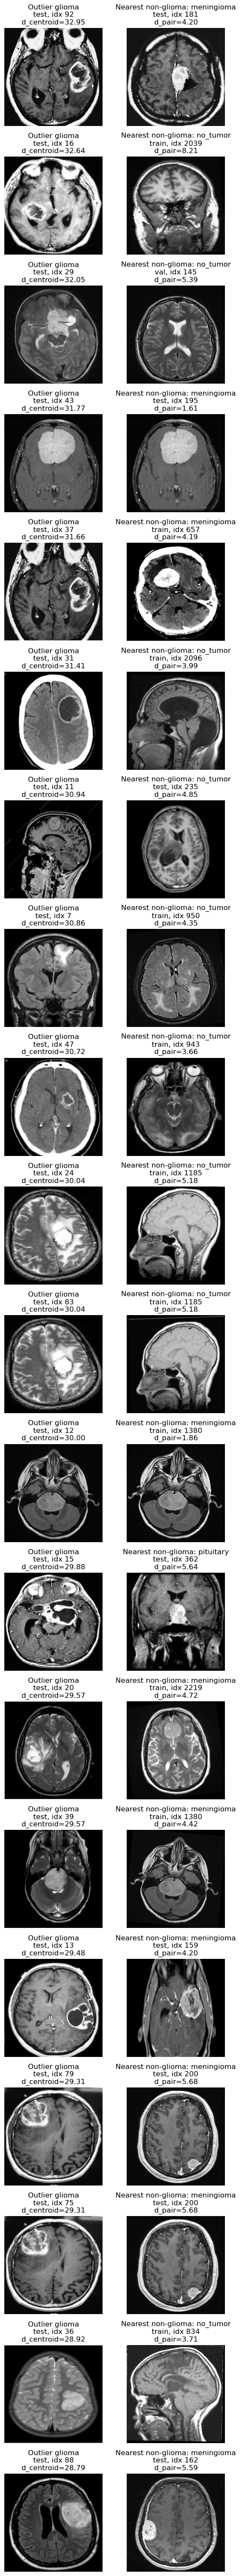

In [27]:
import matplotlib.pyplot as plt

def get_img(split, idx_ds):
    if split == "train":
        img, _ = trainset[idx_ds]
    elif split == "val":
        img, _ = valset[idx_ds]
    else:
        img, _ = testset[idx_ds]
    # img is a tensor [C,H,W]; convert to numpy for plotting
    if isinstance(img, torch.Tensor):
        img_np = img.detach().cpu().numpy()
        if img_np.ndim == 3 and img_np.shape[0] == 1:
            img_np = img_np[0]
        elif img_np.ndim == 3:
            img_np = img_np.transpose(1, 2, 0)
    else:
        img_np = np.array(img)
    return img_np

k_vis = min(top_k, len(pairs))

fig, axes = plt.subplots(k_vis, 2, figsize=(6, 3*k_vis))
if k_vis == 1:
    axes = np.array([axes])  # ensure 2D

for row, (g_idx, n_idx, d_out, d_neigh) in enumerate(pairs[:k_vis]):
    split_g = split_all[g_idx]; idx_g = idx_all[g_idx]
    split_n = split_all[n_idx]; idx_n = idx_all[n_idx]

    img_g = get_img(split_g, idx_g)
    img_n = get_img(split_n, idx_n)

    ax1, ax2 = axes[row]

    ax1.imshow(img_g, cmap="gray")
    ax1.set_title(f"Outlier glioma\n{split_g}, idx {idx_g}\n"
                  f"d_centroid={d_out:.2f}")
    ax1.axis("off")

    ax2.imshow(img_n, cmap="gray")
    ax2.set_title(f"Nearest non-glioma: {class_names[y_all[n_idx]]}\n"
                  f"{split_n}, idx {idx_n}\n"
                  f"d_pair={d_neigh:.2f}")
    ax2.axis("off")

plt.tight_layout()
plt.show()
